# Score cutoffs

This notebook explores the effect of applying score cutoffs prior to calculating docking success rates.

In [1]:
from pathlib import Path

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd
import seaborn as sns

In [2]:
sns.set() # Setting seaborn as default style even if use only matplotlib

In [3]:
OUT_DIR = Path("../pics")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [4]:
fred_results = pd.read_csv("../data/fred_results.csv", index_col=0)
hybrid_results = pd.read_csv("../data/hybrid_results.csv", index_col=0)
posit_results = pd.read_csv("../data/posit_results.csv", index_col=0)

## Default docking score

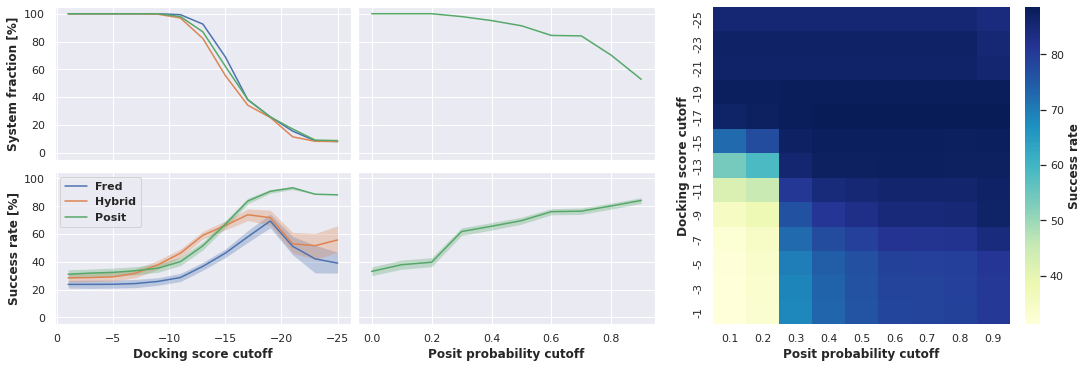

In [5]:
def plot_normalized_score_cutoffs(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # (2 * 2) + 1 subplots
    fig = plt.figure(constrained_layout=True, figsize=(15, 5))
    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[:, 2])
    axes = [[ax1, ax2], [ax3, ax4, ax5]]
        
    # sample docking score cutoffs
    sampled_success_rates = []
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for cutoff in range(-25, 1, 2):
            results_selection = results[results["docking_score"] <= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i =[]
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
    
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["docking_score_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )
    
    # plot docking score cutoffs
    sns.lineplot(data=sampled_success_rates, x="docking_score_cutoff", y="system_fraction", hue="method", ax=axes[0][0])
    axes[0][0].set_ylabel("System fraction [%]", fontweight="bold")
    axes[0][0].set_ylim([-5, 105])
    axes[0][0].xaxis.set_ticklabels([])
    axes[0][0].invert_xaxis()
    axes[0][0].set_xlabel("")
    axes[0][0].get_legend().remove()

    ax = sns.lineplot(data=sampled_success_rates, x="docking_score_cutoff", y="success_rate", hue="method", ci=None, ax=axes[1][0])
    axes[1][0].invert_xaxis()
    axes[1][0].set_xlabel("Docking score cutoff", fontweight="bold")
    axes[1][0].set_ylabel("Success rate [%]", fontweight="bold")
    axes[1][0].set_ylim([-5, 105])
    axes[1][0].legend(prop=dict(weight="bold"), fancybox=True)
    # plot ci
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["docking_score_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["docking_score_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[1].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["docking_score_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[2].get_color(),
        linewidth=0
    )
    
    # sample posit probability cutoffs
    sampled_success_rates2 = []
    for method, results in zip(["Posit"], [posit_results]):
        for cutoff in [x / 10 for x in range(10)]:
            results_selection = results[results["posit_probability"] >= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates2.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
            
    sampled_success_rates2 = pd.DataFrame(
        sampled_success_rates2, columns=["posit_probability_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )
    
    # plot data for posit probability cutoffs
    sns.lineplot(
        data=sampled_success_rates2, 
        x="posit_probability_cutoff", 
        y="system_fraction",  
        ax=axes[0][1],
        color=axes[1][0].get_lines()[2].get_color()
    )
    axes[0][1].set_ylabel("")
    axes[0][1].set_ylim([-5, 105])
    axes[0][1].yaxis.set_ticklabels([])
    axes[0][1].set_xlabel("")
    axes[0][1].xaxis.set_ticklabels([])
    
    ax = sns.lineplot(
        data=sampled_success_rates2, 
        x="posit_probability_cutoff", 
        y="success_rate", 
        ci=None, 
        ax=axes[1][1],
        color=axes[1][0].get_lines()[2].get_color()
    )
    axes[1][1].set_xlabel("Posit probability cutoff", fontweight="bold")
    axes[1][1].set_ylabel("")
    axes[1][1].yaxis.set_ticklabels([])
    axes[1][1].set_ylim([-5, 105])
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["posit_probability_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    
    # plot docking score vs posit probability cutoffs
    success_rates = []
    for posit_probability_cutoff in [x / 10 for x in range(1, 10)]:
        for docking_score_cutoff in range(-25, 1, 2):
            results_selection = posit_results[
                (posit_results["posit_probability"] >= posit_probability_cutoff) &
                (posit_results["docking_score"] <= docking_score_cutoff)
            ]
            success_labels = (results_selection["rmsd"] <= 2).to_list()
            success_rates.append([
                    posit_probability_cutoff,
                    docking_score_cutoff,
                    (sum(success_labels) / len(success_labels)) * 100
                ])
    success_rates = pd.DataFrame(success_rates, columns=["posit_probability_cutoff", "docking_score_cutoff", "success_rate"])
    success_rates = success_rates.pivot("docking_score_cutoff", "posit_probability_cutoff", "success_rate")
    ax = sns.heatmap(success_rates, cmap="YlGnBu", ax=axes[1][2])
    axes[1][2].set_xlabel("Posit probability cutoff", fontweight="bold")
    axes[1][2].set_ylabel("\nDocking score cutoff", fontweight="bold")
    cbar = ax.collections[0].colorbar
    cbar.set_label("Success rate", weight="bold")
    
    plt.savefig(directory / "score_cutoffs.png", dpi=300)
    
    return sampled_success_rates, sampled_success_rates2

docking_score_success_rates, posit_probability_success_rates = plot_normalized_score_cutoffs(
    fred_results, hybrid_results, posit_results
)

In [6]:
docking_score_success_rates

,docking_score_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,-25,Fred,39.057447,31.914894,46.808511,7.979626
1,-23,Fred,42.114000,32.000000,52.000000,8.488964
2,-21,Fred,51.150549,45.054945,58.241758,15.449915
3,-19,Fred,69.393421,64.473684,74.342105,25.806452
4,-17,Fred,57.995089,54.017857,62.500000,38.030560
5,-15,Fred,46.258128,43.103448,49.261084,68.930390
6,-13,Fred,36.764954,33.944954,39.633028,92.529711
7,-11,Fred,28.690769,25.811966,31.623932,99.320883
8,-9,Fred,25.873854,23.089983,28.522920,100.000000
9,-7,Fred,24.346689,21.392190,27.334465,100.000000


In [7]:
posit_probability_success_rates

,posit_probability_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,0.0,Posit,33.115620,30.050934,36.332767,100.000000
1,0.1,Posit,37.924109,34.634975,41.256367,100.000000
2,0.2,Posit,39.678608,36.502547,42.954160,100.000000
3,0.3,Posit,61.810572,58.925477,64.471404,97.962649
4,0.4,Posit,65.611964,62.857143,68.214286,95.076401
5,0.5,Posit,69.622491,67.100372,72.118959,91.341256
6,0.6,Posit,76.124748,73.843058,78.269618,84.380306
7,0.7,Posit,76.468081,74.141414,78.787879,84.040747
8,0.8,Posit,80.244794,77.966102,82.324455,70.118846
9,0.9,Posit,84.187460,81.993569,86.173633,52.801358


## Normalized docking score

The following section will generate the same plot using the docking scores normalized by the respective heavy atom counts. This is a similar metric as the ligand efficiency often employed during lead optimization.

In [8]:
def add_normalized_docking_score(results):
    from rdkit import Chem
    from kinoml.databases.pdb import smiles_from_pdb
    
    expo_ids = results["ligand_expo_id"].unique()
    smiles_dict = smiles_from_pdb(expo_ids)
    ha_count_dict = dict()
    for expo_id, smiles in smiles_dict.items():
        molecule = Chem.MolFromSmiles(smiles)
        ha_count_dict[expo_id] = molecule.GetNumHeavyAtoms()
    
    results["ha_count"] = results["ligand_expo_id"].map(ha_count_dict)
    results["normalized_docking_score"] = results["docking_score"] / results["ha_count"]
        
    return results
        
fred_results = add_normalized_docking_score(fred_results)
hybrid_results = add_normalized_docking_score(hybrid_results)
posit_results = add_normalized_docking_score(posit_results)

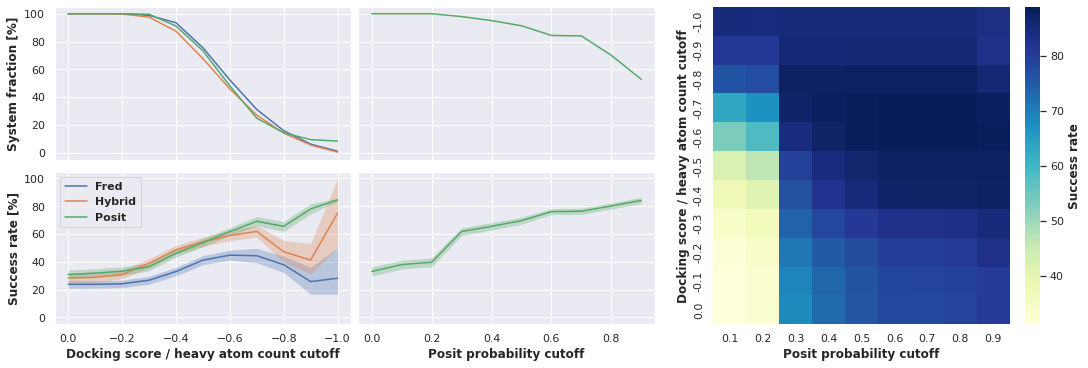

In [9]:
def plot_normalized_score_cutoffs(fred_results, hybrid_results, posit_results, n_bootstrap=1000, ci=0.95, directory=OUT_DIR):
    
    # select pose 1 for Fred and Hybrid, i.e. best pose according to docking score
    fred_results = fred_results[fred_results["pose"] == 1]
    hybrid_results = hybrid_results[hybrid_results["pose"] == 1]
    
    # (2 * 2) + 1 subplots
    fig = plt.figure(constrained_layout=True, figsize=(15, 5))
    gs = GridSpec(2, 3, figure=fig)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    ax3 = fig.add_subplot(gs[1, 0])
    ax4 = fig.add_subplot(gs[1, 1])
    ax5 = fig.add_subplot(gs[:, 2])
    axes = [[ax1, ax2], [ax3, ax4, ax5]]
        
    # sample docking score cutoffs
    sampled_success_rates = []
    for method, results in zip(["Fred", "Hybrid", "Posit"], [fred_results, hybrid_results, posit_results]):
        for cutoff in [x / 10 for x in range(-10, 1)]:
            results_selection = results[results["normalized_docking_score"] <= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i =[]
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
    
    sampled_success_rates = pd.DataFrame(
        sampled_success_rates, 
        columns=["docking_score_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )
    
    # plot docking score cutoffs
    sns.lineplot(data=sampled_success_rates, x="docking_score_cutoff", y="system_fraction", hue="method", ax=axes[0][0])
    axes[0][0].set_ylabel("System fraction [%]", fontweight="bold")
    axes[0][0].set_ylim([-5, 105])
    axes[0][0].xaxis.set_ticklabels([])
    axes[0][0].invert_xaxis()
    axes[0][0].set_xlabel("")
    axes[0][0].get_legend().remove()

    ax = sns.lineplot(data=sampled_success_rates, x="docking_score_cutoff", y="success_rate", hue="method", ci=None, ax=axes[1][0])
    axes[1][0].invert_xaxis()
    axes[1][0].set_xlabel("Docking score / heavy atom count cutoff", fontweight="bold")
    axes[1][0].set_ylabel("Success rate [%]", fontweight="bold")
    axes[1][0].set_ylim([-5, 105])
    axes[1][0].legend(prop=dict(weight="bold"), fancybox=True)
    # plot ci
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["docking_score_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Fred"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["docking_score_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Hybrid"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[1].get_color(),
        linewidth=0
    )
    ax.fill_between(
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["docking_score_cutoff"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates[sampled_success_rates["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[2].get_color(),
        linewidth=0
    )
    
    # sample posit probability cutoffs
    sampled_success_rates2 = []
    for method, results in zip(["Posit"], [posit_results]):
        for cutoff in [x / 10 for x in range(10)]:
            results_selection = results[results["posit_probability"] >= cutoff]
            system_fraction = (
                len(results_selection["ligand_pdb_id"].unique()) / len(results["ligand_pdb_id"].unique())
            ) * 100
            sampled_success_rates_i = []
            for _ in range(n_bootstrap):
                sampled_results = results_selection.groupby(["ligand_pdb_id"]).sample(n=1)
                sampled_success_labels = (sampled_results["rmsd"] <= 2).to_list()
                sampled_success_rates_i.append(
                    (sum(sampled_success_labels) / len(sampled_success_labels)) * 100
                )
            sampled_success_rates_i = sorted(sampled_success_rates_i)
            mean = sum(sampled_success_rates_i) / len(sampled_success_rates_i)
            ci_cutoff = (1 - ci) / 2
            lower_bound = sampled_success_rates_i[int(n_bootstrap * ci_cutoff)]
            upper_bound = sampled_success_rates_i[int(n_bootstrap * (ci + ci_cutoff))]
            sampled_success_rates2.append([cutoff, method, mean, lower_bound, upper_bound, system_fraction])
            
    sampled_success_rates2 = pd.DataFrame(
        sampled_success_rates2, columns=["posit_probability_cutoff", "method", "success_rate", "ci_lower", "ci_upper", "system_fraction"]
    )
    
    # plot data for posit probability cutoffs
    sns.lineplot(
        data=sampled_success_rates2, 
        x="posit_probability_cutoff", 
        y="system_fraction",  
        ax=axes[0][1],
        color=axes[1][0].get_lines()[2].get_color()
    )
    axes[0][1].set_ylabel("")
    axes[0][1].set_ylim([-5, 105])
    axes[0][1].yaxis.set_ticklabels([])
    axes[0][1].set_xlabel("")
    axes[0][1].xaxis.set_ticklabels([])
    
    ax = sns.lineplot(
        data=sampled_success_rates2, 
        x="posit_probability_cutoff", 
        y="success_rate", 
        ci=None, 
        ax=axes[1][1],
        color=axes[1][0].get_lines()[2].get_color()
    )
    axes[1][1].set_xlabel("Posit probability cutoff", fontweight="bold")
    axes[1][1].set_ylabel("")
    axes[1][1].yaxis.set_ticklabels([])
    axes[1][1].set_ylim([-5, 105])
    ax.fill_between(
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["posit_probability_cutoff"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_lower"], 
        sampled_success_rates2[sampled_success_rates2["method"] == "Posit"]["ci_upper"], 
        alpha=0.3,
        color= ax.get_lines()[0].get_color(),
        linewidth=0
    )
    
    # plot docking score vs posit probability cutoffs
    success_rates = []
    for posit_probability_cutoff in [x / 10 for x in range(1, 10)]:
        for docking_score_cutoff in [x / 10 for x in range(-10, 1)]:
            results_selection = posit_results[
                (posit_results["posit_probability"] >= posit_probability_cutoff) &
                (posit_results["normalized_docking_score"] <= docking_score_cutoff)
            ]
            success_labels = (results_selection["rmsd"] <= 2).to_list()
            success_rates.append([
                    posit_probability_cutoff,
                    docking_score_cutoff,
                    (sum(success_labels) / len(success_labels)) * 100
                ])
    success_rates = pd.DataFrame(success_rates, columns=["posit_probability_cutoff", "docking_score_cutoff", "success_rate"])
    success_rates = success_rates.pivot("docking_score_cutoff", "posit_probability_cutoff", "success_rate")
    ax = sns.heatmap(success_rates, cmap="YlGnBu", ax=axes[1][2])
    axes[1][2].set_xlabel("Posit probability cutoff", fontweight="bold")
    axes[1][2].set_ylabel("\nDocking score / heavy atom count cutoff", fontweight="bold")
    cbar = ax.collections[0].colorbar
    cbar.set_label("Success rate", weight="bold")
    
    plt.savefig(directory / "score_cutoffs2.png", dpi=300)
    
    return sampled_success_rates, sampled_success_rates2

docking_score_success_rates, posit_probability_success_rates = plot_normalized_score_cutoffs(
    fred_results, hybrid_results, posit_results
)

In [10]:
docking_score_success_rates

,docking_score_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,-1.0,Fred,28.166667,16.666667,50.000000,1.018676
1,-0.9,Fred,25.761111,16.666667,36.111111,6.112054
2,-0.8,Fred,37.905376,32.258065,44.086022,15.789474
3,-0.7,Fred,44.389071,39.344262,49.726776,31.069610
4,-0.6,Fred,44.796104,41.233766,48.376623,52.292020
5,-0.5,Fred,41.217303,37.977528,44.494382,75.551783
6,-0.4,Fred,32.999274,29.945554,35.934664,93.548387
7,-0.3,Fred,26.741065,23.883162,29.553265,98.811545
8,-0.2,Fred,24.183022,21.392190,26.825127,100.000000
9,-0.1,Fred,23.801868,21.052632,26.485569,100.000000


In [11]:
posit_probability_success_rates

,posit_probability_cutoff,method,success_rate,ci_lower,ci_upper,system_fraction
0,0.0,Posit,33.033786,29.711375,36.332767,100.000000
1,0.1,Posit,37.993548,34.804754,41.086587,100.000000
2,0.2,Posit,39.698302,36.332767,42.784380,100.000000
3,0.3,Posit,61.801733,58.925477,64.471404,97.962649
4,0.4,Posit,65.545893,62.857143,68.214286,95.076401
5,0.5,Posit,69.647955,67.100372,72.118959,91.341256
6,0.6,Posit,76.118511,74.044266,78.269618,84.380306
7,0.7,Posit,76.443838,74.141414,78.585859,84.040747
8,0.8,Posit,80.211864,77.966102,82.324455,70.118846
9,0.9,Posit,84.196785,81.993569,86.495177,52.801358
